# Fitting step responses

It is often prohibitively expensive to develop first principle models of processes and therefore it is very common to estimate low order transfer functions directly from plant data. This is simple to do if we have access to step test results.


In [1]:
import control
import numpy
import matplotlib.pyplot as plt
import tbcontrol
tbcontrol.expectversion("0.1.10")
%matplotlib inline

Let's start with a higher order process to generate our "real data"


In [2]:
Greal = control.tf([1, 2], [2, 3, 4, 1])

In [3]:
ts, ys = control.step_response(Greal)

Remember that the real data will not necessarily start at zero, so we'll add in some value for the initial output. We will also add some normally distributed noise to represent measurement error.


In [4]:
yinitial = 10
measurement_noise = numpy.random.randn(len(ys)) * 0.05

In [5]:
ym = ys + yinitial + measurement_noise

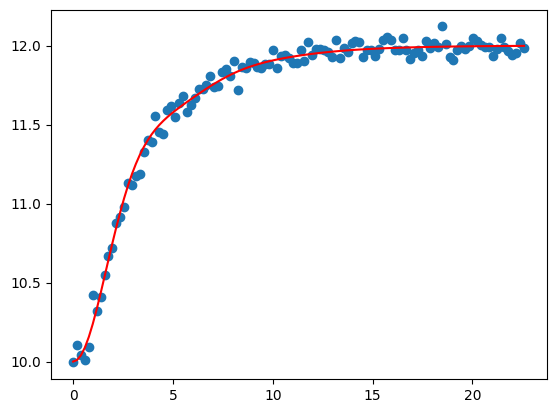

In [6]:
plt.scatter(ts, ym)
plt.plot(ts, ys + yinitial, color="red")

In [7]:
import scipy.optimize

We'll fit a first order plus dead time and second order plus dead time model. The `tbcontrol.responses` library contains the analytic formulae for these step responses.


In [8]:
from tbcontrol.responses import fopdt, sopdt

It is very important to have a good idea of the initial parameter values. Interaction makes it easy to figure out.


In [9]:
from ipywidgets import interact

In [10]:
def resultplot(K, tau, theta, y0):
    plt.scatter(ts, ym)
    plt.plot(ts, fopdt(ts, K, tau, theta, y0), color="red")
    plt.show()

In [11]:
interact(resultplot, K=(1.0, 10.0), tau=(0.0, 10.0), theta=(0.0, 10.0), y0=(0.0, 20.0))

interactive(children=(FloatSlider(value=5.5, description='K', max=10.0, min=1.0), FloatSlider(value=5.0, descr…

<function __main__.resultplot(K, tau, theta, y0)>

We can use the `scipy.optimize.curve_fit` tool to do this fit just like when we did regression without time.


In [12]:
[K, tau, theta, y0], _ = scipy.optimize.curve_fit(fopdt, ts, ym, [2, 4, 1, 10])
[K, tau, theta, y0]

[1.9520968959015466, 2.841596949064128, 0.6372125498762794, 10.037651576496101]

The parameters for the second order model should be similar, with a smaller time constant and overdamped nature.


In [13]:
[K_2, tau_2, zeta_2, theta_2, y0_2], _ = scipy.optimize.curve_fit(
    sopdt, ts, ym, [2, 2, 1.5, 1, 10]
)
[K_2, tau_2, zeta_2, theta_2, y0_2]

/mnt/c/Users/SimonStreicher/repos/Dynamics-and-Control/tbcontrol/responses.py:60: RuntimeWarning: overflow encountered in cosh
  * (coslike(root * ttau) + zeta / root * sinlike(root * ttau))
/mnt/c/Users/SimonStreicher/repos/Dynamics-and-Control/tbcontrol/responses.py:60: RuntimeWarning: overflow encountered in sinh
  * (coslike(root * ttau) + zeta / root * sinlike(root * ttau))


[1.9520972794603226,
 0.20951948651686975,
 6.818087052668007,
 0.6217207770467881,
 10.037651228736177]

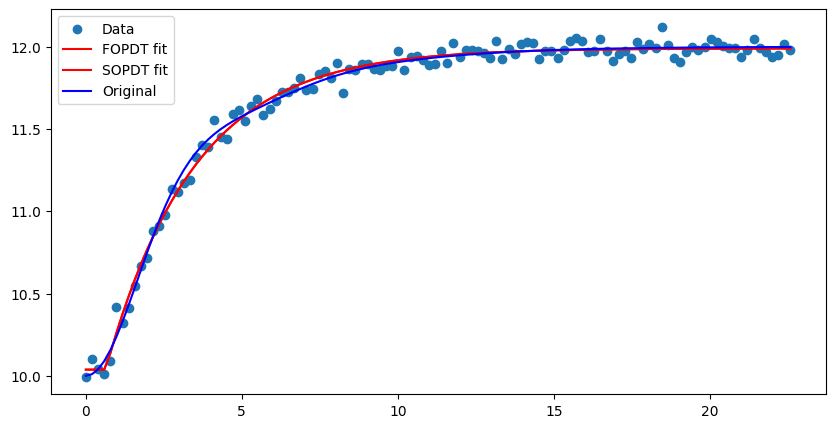

In [14]:
plt.figure(figsize=(10, 5))
plt.scatter(ts, ym, label="Data")
plt.plot(ts, fopdt(ts, K, tau, theta, y0), color="red", label="FOPDT fit")
plt.plot(
    ts, sopdt(ts, K_2, tau_2, zeta_2, theta_2, y0_2), color="red", label="SOPDT fit"
)
plt.plot(ts, ys + 10, color="blue", label="Original")
plt.legend(loc="best")